In [1]:
import os 
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

keras = tf.keras

In [2]:
import tensorflow_datasets as tfds
tfds.disable_progress_bar()
setattr(tfds.image_classification.cats_vs_dogs, '_URL',"https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip")
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

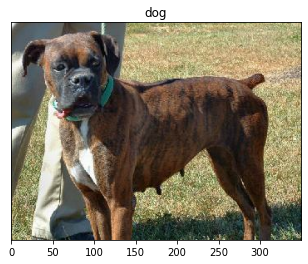

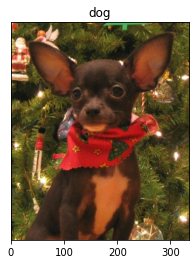

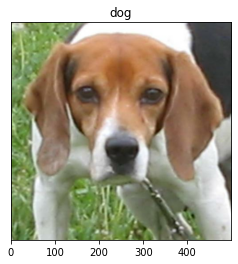

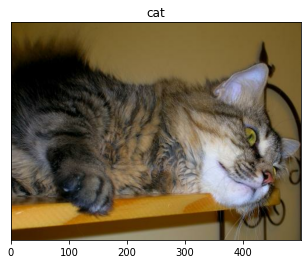

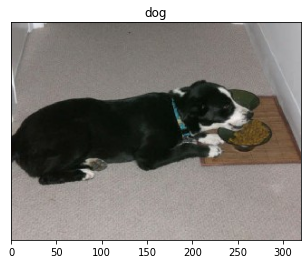

In [3]:
get_label_name = metadata.features['label'].int2str # creates a function object that we can use to get labels

for image, label in raw_train.take(5):
  plt.figure()
  plt.yticks([])
  plt.imshow(image)
  plt.title(get_label_name(label))

In [4]:
IMG_SIZE = 160 # All images will be resized to 160x160

def format_example(image, label):
  image = tf.cast(image, tf.float32) # convert the image type to uint8
  image = (image/127.5) - 1 # Normalize the image to [-1, 1]
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
  return image, label

In [5]:
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

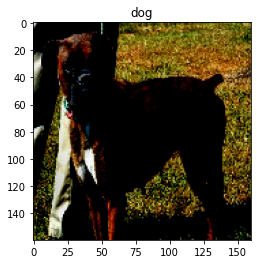

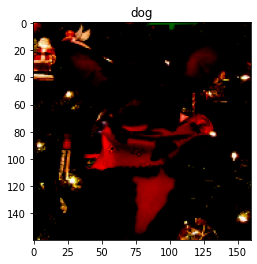

In [15]:
for image, label in train.take(2):
  plt.figure()
  plt.imshow(image, cmap='gray')
  plt.title(get_label_name(label))

In [16]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

In [7]:
for img, label in raw_train.take(2):
  print(img.shape)
for img, label in train.take(2):
  print(img.shape)

(262, 350, 3)
(409, 336, 3)
(160, 160, 3)
(160, 160, 3)


In [8]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,include_top=False, 
weights='imagenet')

In [14]:
# base_model.summary()

In [19]:
for image, _ in train_batches.take(1):
  pass
feature_batch = base_model(image)
print(feature_batch)

tf.Tensor(
[[[[0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         3.1122394  ... 0.         0.
    0.        ]
   [0.         0.         2.9919415  ... 0.         0.
    0.        ]
   [0.         0.         0.9763117  ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]]

  [[0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.32014704 ... 0.         0.7108536
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]]

  [[0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         1.6999941  ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         1.2432122  ... 0.         0.


In [21]:
base_model.trainable = False

In [22]:
global_avg_layer = tf.keras.layers.GlobalAveragePooling2D()

In [23]:
prediction_layer = keras.layers.Dense(1)

In [24]:
model = tf.keras.Sequential([
  base_model,
  global_avg_layer,
  prediction_layer
])

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [29]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate),loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),metrics=['accuracy'])

In [32]:
initial_epochs = 3
validation_steps = 20

loss0, accuracy0 = model.evaluate(validation_batches, steps=validation_steps)

20/20 [==============================] - 10s 509ms/step - loss: 0.0569 - accuracy: 0.9719


In [33]:
history  = model.fit(train_batches, epochs=initial_epochs, validation_data=validation_batches, validation_steps=validation_steps)

Epoch 1/3
582/582 [==============================] - 284s 485ms/step - loss: 0.0512 - accuracy: 0.9808 - val_loss: 0.0551 - val_accuracy: 0.9766
Epoch 2/3
582/582 [==============================] - 273s 466ms/step - loss: 0.0480 - accuracy: 0.9822 - val_loss: 0.0527 - val_accuracy: 0.9797
Epoch 3/3
582/582 [==============================] - 290s 496ms/step - loss: 0.0459 - accuracy: 0.9828 - val_loss: 0.0520 - val_accuracy: 0.9797
[0.9808167815208435, 0.9822138547897339, 0.9828049540519714]


In [37]:
acc = history.history['val_accuracy']
print(acc)

[0.9765625, 0.979687511920929, 0.979687511920929]


In [ ]:
model.save('cats_and_dogs_small_1.h5')
new_model = tf.keras.models.load_model('cats_and_dogs_small_1.h5')